In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import pdist, squareform

read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


      Id           Centres
0      0    [362.5, 116.0]
1      1    [646.5, 114.5]
2      2    [842.0, 116.0]
3      3   [1173.5, 119.5]
4      4   [1281.0, 118.0]
..   ...               ...
493  493  [1653.0, 3289.5]
494  494  [1806.5, 3288.0]
495  495  [2029.0, 3286.5]
496  496  [2141.5, 3282.5]
497  497  [2229.5, 3281.5]

[498 rows x 2 columns]


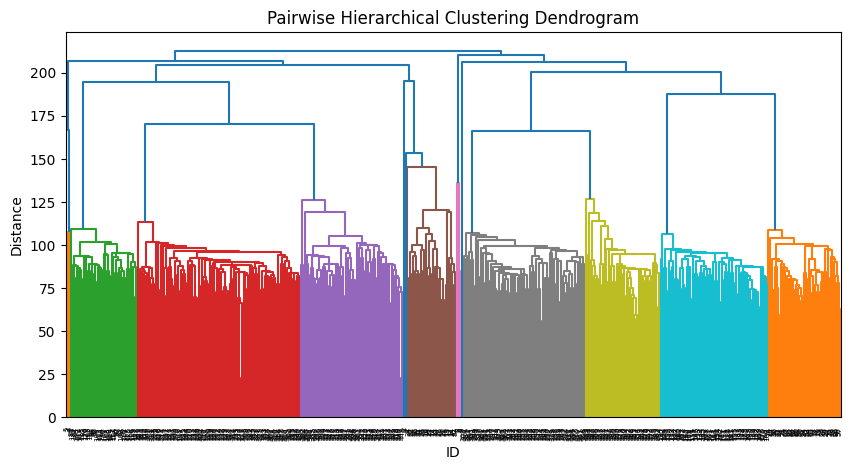

Number of Different Colors Used: 10
Cluster ID 103: IDs [367, 371, 358, 366, 493, 488, 494, 492, 487, 480, 458, 466, 473, 457, 465, 472, 495, 481, 477, 482, 496, 486, 490, 497, 469, 470, 471, 479, 450, 460, 464, 462, 452, 463, 456, 455, 453, 454, 451, 449, 461, 468, 475, 476, 459, 467, 474]
      Id           Centres       X       Y
330  330   [653.0, 2473.0]   653.0  2473.0
331  331   [753.0, 2469.5]   753.0  2469.5
332  332   [907.5, 2478.0]   907.5  2478.0
333  333  [1032.0, 2472.5]  1032.0  2472.5
334  334  [1460.0, 2245.5]  1460.0  2245.5
335  335  [1583.0, 2235.5]  1583.0  2235.5
336  336  [1433.0, 2312.5]  1433.0  2312.5
337  337  [1518.0, 2310.5]  1518.0  2310.5
338  338  [1601.0, 2308.5]  1601.0  2308.5
339  339  [1704.0, 2310.5]  1704.0  2310.5
340  340  [1776.5, 2237.5]  1776.5  2237.5
341  341  [1916.5, 2237.5]  1916.5  2237.5
342  342  [2069.0, 2235.5]  2069.0  2235.5
343  343  [2218.5, 2237.5]  2218.5  2237.5
344  344  [1885.5, 2307.0]  1885.5  2307.0
345  345  [1997.5, 2

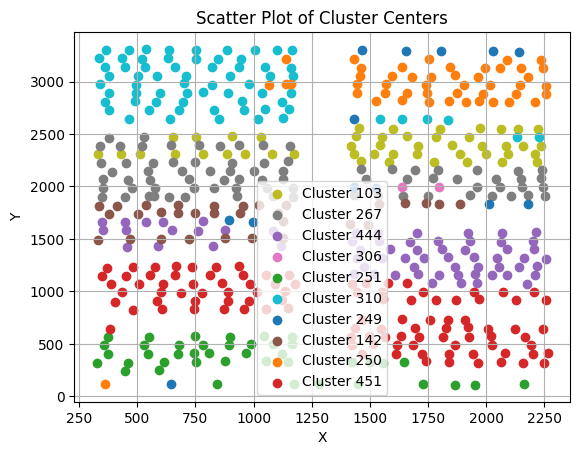

In [2]:
df = pd.read_csv('Bounding-Boxes/CSV/TLBR_68.csv')
def parse_coordinates(coord_str):
    # Parse the string as a JSON array
    coord_list = json.loads(coord_str)
    # Extract 'x' and 'y' values
    x, y = coord_list
    return int(x), int(y)

# Create the 'euclidean' DataFrame and initialize it with columns
euclidean = pd.DataFrame(columns=['Id', 'Top', 'Bottom', 'Left', 'Right', 'Top_Box', 'Bottom_Box', 'Left_Box', 'Right_Box'])
df1 = pd.DataFrame(columns=['Id', 'Centres'])
for index, row in df.iterrows():
    top_left = parse_coordinates(row['Top-Left'])
    bottom_right = parse_coordinates(row['Bottom-Right'])
    box_id = row['Id']
    # Calculate edge centers
    top_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, top_left[1])
    bottom_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, bottom_right[1])
    left_center = (top_left[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)
    right_center = (bottom_right[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)

    # Initialize neighbor values to -1 and 0
    top_box = (-1, 0)
    bottom_box = (-1, 0)
    left_box = (-1, 0)
    right_box = (-1, 0)

    # Add the row to the 'euclidean' DataFrame
    euclidean.loc[index] = [box_id, top_center, bottom_center, left_center, right_center, top_box, bottom_box, left_box, right_box]
    df1.loc[index] = [box_id, [(top_left[0]+bottom_right[0])/2, (top_left[1]+bottom_right[1])/2]]
print(df1)
df1[['X', 'Y']] = pd.DataFrame(df1['Centres'].tolist(), columns=['X', 'Y'])
# chebyshev_distances = pdist(df1[['X', 'Y']].values, metric='chebyshev')

# # Convert the condensed distance matrix to squareform
# square_distance_matrix = squareform(chebyshev_distances)

# # Calculate the linkage matrix for hierarchical clustering using Chebyshev distances
# linkage_matrix = linkage(square_distance_matrix, method='average')
linkage_matrix = linkage(df1[['X', 'Y']], method='single', metric='minkowski')
plt.figure(figsize=(10, 5))
dendro = dendrogram(linkage_matrix, labels=df1['Id'].tolist(), orientation='top', distance_sort='ascending')
plt.xlabel('ID')
plt.ylabel('Distance')
plt.title('Pairwise Hierarchical Clustering Dendrogram')
plt.show()
cluster_labels = fcluster(linkage_matrix, t=5, criterion='distance')  # Adjust the threshold 't' as needed
cluster_id_mapping = {}
for id_, label in zip(dendro['ivl'], cluster_labels):
    cluster_id_mapping[id_] = label
# Get the colors assigned to the labels in the dendrogram
label_colors = [dendro['color_list'][i] for i in range(len(dendro['color_list']))]

# Count the unique colors
unique_colors = set(label_colors)
num_unique_colors = len(unique_colors)

print(f'Number of Different Colors Used: {num_unique_colors}')
for color in unique_colors:
    ids_in_cluster = [id_ for id_, label_color in zip(dendro['ivl'], label_colors) if label_color == color]
    cluster_id = cluster_id_mapping.get(ids_in_cluster[0], None)  # Get cluster ID from the mapping
    print(f'Cluster ID {cluster_id}: IDs {ids_in_cluster}')
    cluster_centers = df1[np.isin(dendro['ivl'], ids_in_cluster)]
    print(cluster_centers)
    # Scatter plot for the cluster with its assigned color
    plt.scatter(cluster_centers['X'], cluster_centers['Y'], label=f'Cluster {cluster_id}', c=color)
# Customize the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Cluster Centers')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
vertical_distances = []
horizontal_distances = []
def find_nearest_box(row, direction):
    min_distance = float('inf')
    nearest_box = [-1, 0]

    for index, other_row in euclidean.iterrows():
        if row['Id'] != other_row['Id']:
            distance = float('inf')
            calc = euclidean_distance([(row['Top'][0]+row['Bottom'][0])/2, (row['Top'][1]+row['Bottom'][1])/2  ],[ (other_row['Top'][0]+other_row['Bottom'][0])/2, (other_row['Top'][1]+other_row['Bottom'][1])/2 ])
            if(direction == 'Top'):
                if(row['Top'] < other_row['Bottom']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Bottom'):
                if(row['Bottom'] > other_row['Top']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Left'):
                if(row['Left'] < other_row['Right']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Right'):
                if(row['Right'] > other_row['Left']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if distance < min_distance:
                min_distance = distance
                nearest_box = [min_distance, other_row['Id']+1]

    return nearest_box

# Iterate through the 'euclidean' DataFrame to find the nearest boxes in each direction

for index, row in euclidean.iterrows():
    euclidean.at[index, 'Top_Box'] = find_nearest_box(row, 'Top')
    euclidean.at[index, 'Bottom_Box'] = find_nearest_box(row, 'Bottom')
    euclidean.at[index, 'Left_Box'] = find_nearest_box(row, 'Left')
    euclidean.at[index, 'Right_Box'] = find_nearest_box(row, 'Right')
    if(euclidean.at[index, 'Top_Box'][0] != -1):
        vertical_distances.append(euclidean.at[index, 'Top_Box'][0])
    if(euclidean.at[index, 'Left_Box'][0] != -1):
        horizontal_distances.append(euclidean.at[index, 'Left_Box'][0])

In [3]:
img = cv2.imread('Bounding-Boxes/images/68.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [4]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)

In [5]:
def make_connections(image):
#   print(image)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   print(image_rgb)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])
      
      # print(bottom_adjacent_id)
      
      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id-1].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id-1].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id-1].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id-1].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

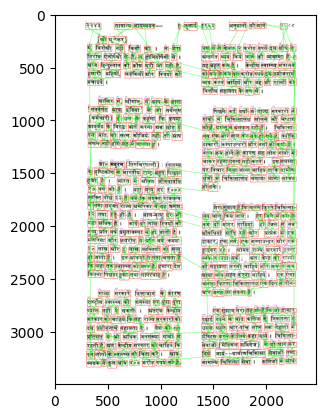

In [6]:
# visualize_bboxes(img)
plt.imshow(make_connections(img))

In [ ]:
# import cv2
# import numpy as np

# # Load image, grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('images/159.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (7,7), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Create rectangular structuring element and dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# dilate = cv2.dilate(thresh, kernel, iterations=10)

# # Find contours and draw rectangle
# cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     x,y,w,h = cv2.boundingRect(c)
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
# print(len(cnts))
# # cv2.imshow('thresh', thresh)
# # cv2.imshow('dilate', dilate)
# cv2.imshow('image', image)
# cv2.waitKey()